In [1]:
import sys
sys.path.append('/Users/Sofie/Documents/DCL/DCLmeetsRETUNE/image_analysis_pipeline/')

In [2]:
from findmycells.main import Project
from findmycells.quantifications import ReconstructCellsIn3DFrom2DInstanceLabels, CountCellsInWholeStructure
#from findmycells.inspection import InspectUsingMultiMatchIDX

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
#import pingouin as pg
import matplotlib.pyplot as plt
from scipy.stats import shapiro
import scipy
import statsmodels.formula.api as smf
from scipy.stats import norm, levene
import statistics
#import statsmodels.api as sm
import pingouin as pg

## Load and Prepare the Data

In [5]:
df = pd.read_csv('counted_cells.csv')

In [6]:
df.tail(10)

,Unnamed: 0,file_id,group_id,subject_id,analyzed_area,total_planes,connected_components,cc_normalized_per_area,cc_normalized_per_volume
51,51,54,wt,#7_wt_old,8767360.0,9.0,86.0,130.837103,14.537456
52,52,55,wt,#7_wt_old,5892928.0,8.0,12.0,27.161354,3.395169
53,53,56,wt,#7_wt_old,4314688.0,9.0,70.0,216.396361,24.044040
54,54,57,wt,#9_wt_old,5140832.0,8.0,46.0,119.350909,14.918864
55,55,58,wt,#9_wt_old,4477600.0,8.0,71.0,211.501944,26.437743
56,56,59,wt,#9_wt_old,7410528.0,9.0,184.0,331.184482,36.798276
57,57,60,wt,#9_wt_old,7109728.0,10.0,152.0,285.162170,28.516217
58,58,61,wt,#9_wt_old,5770116.0,9.0,123.0,284.329471,31.592163
59,59,62,wt,#9_wt_old,5751712.0,9.0,86.0,199.435575,22.159508
60,60,63,wt,#9_wt_old,4715968.0,10.0,96.0,271.519917,27.151992


In [7]:
df.describe()

,Unnamed: 0,file_id,analyzed_area,total_planes,connected_components,cc_normalized_per_area,cc_normalized_per_volume
count,61.000000,61.000000,6.100000e+01,61.000000,61.000000,61.000000,61.000000
mean,30.000000,31.622951,5.329419e+06,8.442623,63.295082,159.958337,18.747975
std,17.752934,19.069316,1.715786e+06,0.940294,36.455152,84.831816,9.527849
min,0.000000,0.000000,4.195400e+05,6.000000,0.000000,0.000000,0.000000
25%,15.000000,15.000000,4.477600e+06,8.000000,41.000000,92.881431,11.610179
50%,30.000000,33.000000,5.251488e+06,8.000000,65.000000,169.548150,19.004340
75%,45.000000,48.000000,6.312800e+06,9.000000,83.000000,216.396361,26.251630
max,60.000000,63.000000,9.264510e+06,11.000000,184.000000,331.184482,39.079717


## Let's check normality

In [8]:
def check_normality(self):
    stat, p = shapiro(self['cc_normalized_per_volume'])
    ax = sns.distplot(model.resid, hist = False, kde_kws = {"shade" : True, "lw": 1}, fit = scipy.stats.norm)
    if p >= 0.05:
        print("Normality can be assumed")
        model = smf.mixedlm("cc_normalized_per_volume ~ group_id", df, groups = "subject_id").fit()
    else:
        print("WARNING: Normality is violated. Run non-parametric model")

In [9]:
#Check it's running before putting it into the model
model = smf.mixedlm("cc_normalized_per_volume ~ group_id", df, groups = "subject_id").fit()
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
======================================================================
Model:            MixedLM Dependent Variable: cc_normalized_per_volume
No. Observations: 61      Method:             REML                    
No. Groups:       10      Scale:              45.9057                 
Min. group size:  4       Log-Likelihood:     -208.4239               
Max. group size:  7       Converged:          Yes                     
Mean group size:  6.1                                                 
------------------------------------------------------------------------
                    Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
------------------------------------------------------------------------
Intercept           18.494      3.538    5.227   0.000   11.559   25.429
group_id[T.wt]      -0.083      4.994   -0.017   0.987   -9.871    9.705
subject_id Var      54.667      4.923                                   
======================================================================

"""

### Non-parametric model for repeated measures?

In [29]:
#subset for Friedman model
df_friedman = df[["group_id", "subject_id", "cc_normalized_per_volume"]]
df_friedman.head(20)

,group_id,subject_id,cc_normalized_per_volume
0,tg,#10_tg_old,0.000000
1,tg,#10_tg_old,18.729920
2,tg,#10_tg_old,8.306840
3,tg,#10_tg_old,4.944721
4,tg,#10_tg_old,24.454311
5,tg,#10_tg_old,26.251630
6,tg,#11_tg_old,26.598050
7,tg,#11_tg_old,39.079717
8,tg,#11_tg_old,21.447865
9,tg,#11_tg_old,28.997950


In [ ]:
#Problem: I can't figure out if this works when we're only dealing with 2 levels or what the data format should be
#pg.friedman(df_friedman)

### Plotting Normality

/Users/Sofie/opt/anaconda3/envs/DCL_image/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


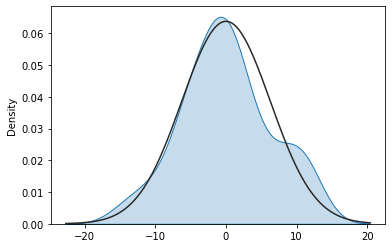

In [10]:
#2 types of normality plots
ax = sns.distplot(model.resid, hist = False, kde_kws = {"shade" : True, "lw": 1}, fit = scipy.stats.norm)

#Problem: the histogram doesn't seem to represent our data - figure out why when you have time
#def map_pdf(x, **kwargs):
#    mu, std = scipy.stats.norm.fit(x)
#    x0, x1 = p1.axes[0][0].get_xlim()  # axes for p1 is required to determine x_pdf
#    x_pdf = np.linspace(x0, x1, 100)
#    y_pdf = scipy.stats.norm.pdf(x_pdf, mu, std)
#    plt.plot(x_pdf, y_pdf, c='r')


#p1 = sns.displot(data=df, x='cc_normalized_per_volume', kind='hist', bins=40, stat='density')
#p1.map(map_pdf, 'cc_normalized_per_volume')

((array([-2.28017173, -1.92017484, -1.7091256 , -1.55469152, -1.43036801,
         -1.3249031 , -1.23241216, -1.14940983, -1.07365152, -1.00360143,
         -0.93815914, -0.87650695, -0.81801894, -0.76220403, -0.70866868,
         -0.65709167, -0.60720655, -0.55878903, -0.51164772, -0.46561731,
         -0.42055328, -0.37632784, -0.33282677, -0.28994682, -0.24759369,
         -0.20568029, -0.16412527, -0.12285188, -0.08178679, -0.04085922,
          0.        ,  0.04085922,  0.08178679,  0.12285188,  0.16412527,
          0.20568029,  0.24759369,  0.28994682,  0.33282677,  0.37632784,
          0.42055328,  0.46561731,  0.51164772,  0.55878903,  0.60720655,
          0.65709167,  0.70866868,  0.76220403,  0.81801894,  0.87650695,
          0.93815914,  1.00360143,  1.07365152,  1.14940983,  1.23241216,
          1.3249031 ,  1.43036801,  1.55469152,  1.7091256 ,  1.92017484,
          2.28017173]),
  array([ 0.        ,  0.        ,  3.36498007,  3.39516929,  4.56467076,
          4.94

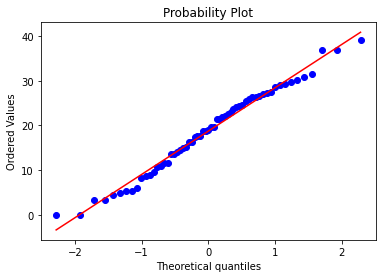

In [11]:
scipy.stats.probplot(df['cc_normalized_per_volume'], dist="norm", plot=plt)

In [12]:
#problem: module 'statsmodels' has no attribute 'api' - should show QQ plot
#sm.qqplot(df['cc_normalized_per_volume'], line='45')
#pylab.show()

AttributeError: module 'statsmodels' has no attribute 'api'

## Checking homoscedasticity

In [ ]:
#Make dataframes compatible for Levene's test
df_tg = df.loc[df['group_id'] == 'tg']
df_tg = df_tg.rename(columns={"cc_normalized_per_volume": "tg"})

df_wt = df.loc[df['group_id'] == 'wt']
df_wt = df_wt.rename(columns={"cc_normalized_per_volume": "wt"})

In [73]:
stat, p = levene(df_wt['wt'], df_tg['tg'])
if p >= 0.05:
        print("Homoscedasticity assumption met!")
else:
        print("WARNING: Homoscedasticity is violated. Consider data transformations")

Homoscedasticity assumption met!


## Get familiar with sns

In [14]:
sns.set_theme()

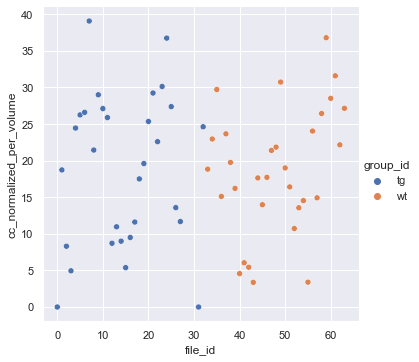

In [15]:
sns.relplot(data=df, x="file_id", y="cc_normalized_per_volume", hue="group_id")

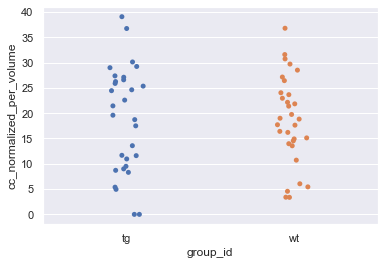

In [16]:
sns.stripplot(data=df, x='group_id', y='cc_normalized_per_volume')

Example of a regression plot

Text(0.5, 1.0, 'correlation between normalized area and volume')

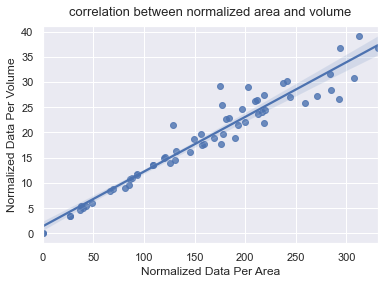

In [17]:
sns.regplot(data=df, x='cc_normalized_per_area', y='cc_normalized_per_volume')
plt.xlabel('Normalized Data Per Area', fontsize=12)
plt.ylabel('Normalized Data Per Volume', fontsize=12)
#ax.spines['right'].set_visible(False)
#ax.spines['top'].set_visible(False)
#plt.text(17, 95, 'r = 0.68\np = 0.03', fontsize=11)
plt.title('correlation between normalized area and volume', fontsize=13, pad=10)
#plt.savefig('correlation_analysis_expert_vs_findmycells.png', dpi=300)
#plt.show()